#Install Requirements

In [4]:
!pip install sentence_transformers

In [5]:
!pip install spacy

In [ ]:
!pip install xgboost

In [6]:
!python -m spacy download en_core_web_sm

In [ ]:
import spacy
nlp_en = spacy.load("en_core_web_sm")

In [10]:
import sentence_transformers
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange
from sklearn.cluster import KMeans
import json
import re
from collections import Counter
import tqdm
import matplotlib.pyplot as plt

# Load Model


In [ ]:
t5 = SentenceTransformer('sentence-transformers/sentence-t5-base')
labse = SentenceTransformer('sentence-transformers/labse')
distiluse = SentenceTransformer('distiluse-base-multilingual-cased-v2')

In [ ]:
model = t5

## Import the datasets


In [11]:
file_path = ".../guerreiro2022_corpus_w_annotations.csv"

guerreiro_df = pd.read_csv(file_path)

print(guerreiro_df.shape)

(3415, 10)


In [12]:
with open("train.model-aware.v2.json", "r") as f:
    data = json.load(f)

train_df_aware = pd.json_normalize(data)
train_df_aware.shape

(30000, 6)

In [ ]:
with open("train.model-agnostic.json", "r") as f:
    data = json.load(f)

train_df_agnostic = pd.json_normalize(data)
train_df_agnostic.shape

(30000, 6)

In [ ]:
with open("test.model-aware.json", "r") as f:
    data = json.load(f)

test_df_aware = pd.json_normalize(data)
test_df_aware.shape

(1500, 6)

In [ ]:
with open("test.model-agnostic.json", "r") as f:
    data = json.load(f)

test_df_agnostic = pd.json_normalize(data)
test_df_agnostic.shape

(1500, 5)

In [ ]:
with open("val.model-aware.json", "r") as f:
    data = json.load(f)

val_df_aware = pd.json_normalize(data)
val_df_aware.shape


(501, 9)

In [ ]:
with open("val.model-agnostic.json", "r") as f:
    data = json.load(f)

val_df_agnostic = pd.json_normalize(data)
val_df_agnostic.shape

(499, 9)

In [13]:
def model_recognition(df):
    model_column = 'model'

    plt.figure(figsize=(10, 8))
    ax = df[model_column].value_counts().plot(kind='bar', color='skyblue', width=0.6)

    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=18)

    plt.title('Distribution of Models in Test Set', fontsize=20)
    plt.xlabel('Models', fontsize=18)
    plt.ylabel('Count', fontsize=18)
    plt.xticks(rotation=25, ha='right', fontsize=18)
    plt.yticks(fontsize=20)
    plt.show()

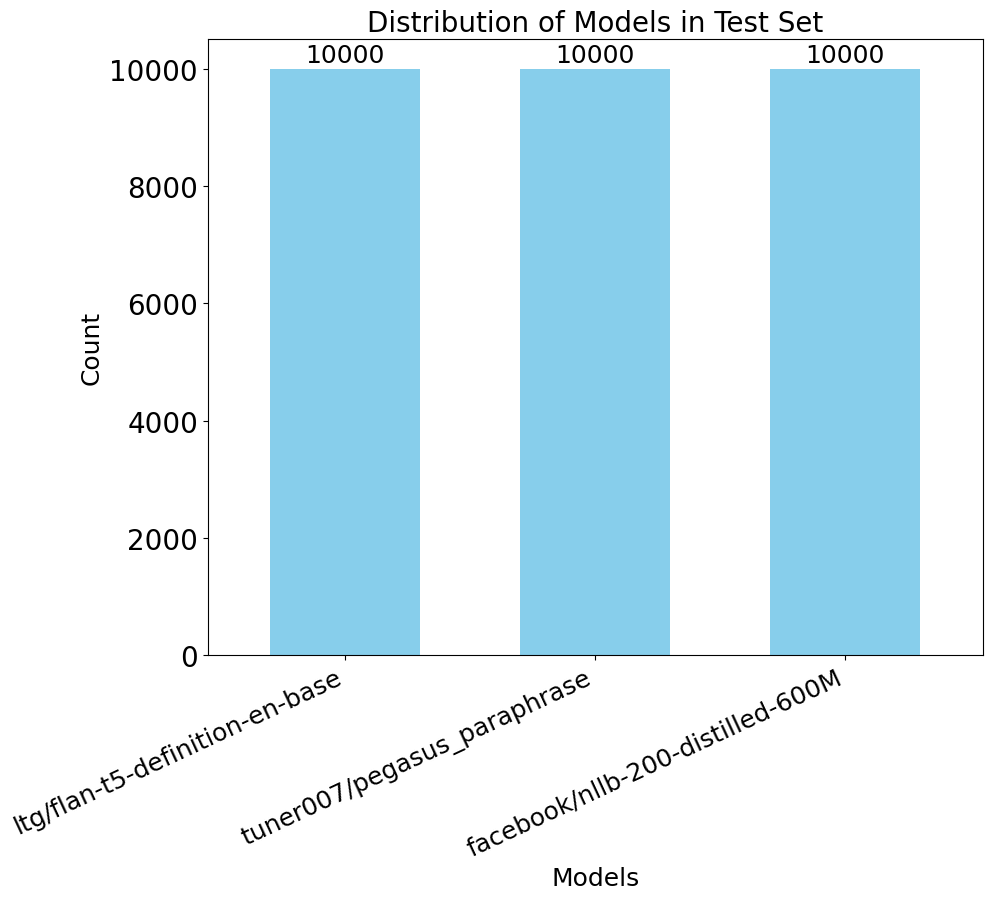

In [14]:
model_recognition(train_df_aware)

# Text Preprocessing

In [ ]:
def extract_word(text):
    match = re.search(r'< define >(.*?)< /define >', text)
    return match.group(1) if match else None

In [ ]:
ar = nlp_en.get_pipe('attribute_ruler')

ar.add([[{"TEXT":"'ve"}]],{"LEMMA":"have"})
ar.add([[{"TEXT":"'m"}]],{"LEMMA":"be"})
ar.add([[{"TEXT":"n't"}]],{"LEMMA":"not"})
ar.add([[{"TEXT":"'ll"}]],{"LEMMA":"will"})
ar.add([[{"TEXT":"'re"}]],{"LEMMA":"be"})

In [ ]:
def preprocess(original_df):

  df = original_df

  df['context'] = ""
  df['word_to_define'] = ""

  for i in tqdm.trange(len(df)):

    df.at[i, 'hyp'] = " ".join(token.lemma_ for token in nlp_en(df.iloc[i]['hyp']) if not token.is_punct)
    df.at[i, 'tgt'] = " ".join(token.lemma_ for token in nlp_en(df.iloc[i]['tgt']) if not token.is_punct)
    if pd.isna(df.at[i, 'src']):
      df.at[i, 'src'] = ''
    else:
      df.at[i, 'src'] = " ".join(token.lemma_ for token in nlp_en(df.iloc[i]['src']) if not token.is_punct)


    hyp = nlp_en(df.at[i, 'hyp'])
    tgt = nlp_en(df.at[i, 'tgt'])
    src = nlp_en(df.at[i, 'src'])

    if df.at[i, 'task'] == 'DM':
      df.at[i, 'word_to_define'] = extract_word(df.at[i, 'src'])
    else:
      df.at[i, 'word_to_define'] = '-'

    hyp_tokens = [token.text for token in hyp]
    tgt_tokens = [token.text for token in tgt]

    if 'model' in df.columns:
      df = pd.get_dummies(df, columns=['model'], prefix='model')
      model_columns = [col for col in df.columns if col.startswith('model_')]
      df[model_columns] = df[model_columns].astype(int)

    intersection = dict(Counter(hyp_tokens) & Counter(tgt_tokens))
    mutual_words = list(intersection.keys())

    df.at[i, 'num_of_common'] = len(mutual_words)

    if df.at[i, 'task'] == 'PG':
      df.at[i, 'context'] = df.at[i, 'src']
    else:
      df.at[i, 'context'] = df.at[i, 'tgt']

  return df


preprocess_2 for Guerreiro Dataset

In [ ]:
def preprocess_2(original_df):

  df = original_df


  for i in tqdm.trange(len(df)):

    df.at[i, 'mt'] = " ".join(token.lemma_ for token in nlp_en(df.iloc[i]['mt']) if not token.is_punct)
    df.at[i, 'ref'] = " ".join(token.lemma_ for token in nlp_en(df.iloc[i]['ref']) if not token.is_punct)


    mt = nlp_en(df.at[i, 'mt'])
    ref = nlp_en(df.at[i, 'ref'])

  return df


In [ ]:
guerreiro_df_processed = preprocess_2(guerreiro_df)

100%|██████████| 3415/3415 [02:23<00:00, 23.85it/s]


In [ ]:
val_df_aware_processed = preprocess(val_df_aware)

100%|██████████| 501/501 [00:30<00:00, 16.49it/s]


In [ ]:
val_df_agnostic_processed = preprocess(val_df_agnostic)

100%|██████████| 499/499 [00:28<00:00, 17.22it/s]


In [ ]:
test_df_aware_processed = preprocess(test_df_aware)

100%|██████████| 1500/1500 [01:28<00:00, 17.01it/s]


In [ ]:
test_df_agnostic_processed = preprocess(test_df_agnostic)

100%|██████████| 1500/1500 [02:28<00:00, 10.13it/s]


In [ ]:
train_df_aware_processed = preprocess(train_df_aware)

  0%|          | 0/30000 [00:00<?, ?it/s]

100%|██████████| 30000/30000 [30:39<00:00, 16.31it/s] 


In [ ]:
train_df_agnostic_processed = preprocess(train_df_agnostic)

100%|██████████| 30000/30000 [26:21<00:00, 18.97it/s] 


# Extract Embeddings

In [ ]:
import pickle

def get_embeddings(df, save_path):
    new_df = df

    if 'hyp' in df.columns:
        emb_hyp = model.encode(df.hyp.tolist(), show_progress_bar=True)
        emb_con = model.encode(df.context.tolist(), show_progress_bar=True)
        sims = (emb_con * emb_hyp).sum(1)

        embeddings_dict = {
        "emb_hyp": emb_hyp,
        "emb_con": emb_con,
        "sims": sims.tolist()
        }
    elif 'mt' in df.columns:
        emb_mt = model.encode(df.mt.tolist(), show_progress_bar=True)
        emb_ref = model.encode(df.ref.tolist(), show_progress_bar=True)
        sims = (emb_ref * emb_mt).sum(1)

        embeddings_dict = {
        "emb_mt": emb_mt,
        "emb_ref": emb_ref,
        "sims": sims.tolist()
        }

    new_df["full_prob"] = 1 - sims
    new_df["sims"] = sims

    with open(save_path, "wb") as f:
        pickle.dump(embeddings_dict, f)

    return new_df


In [ ]:
guerreiro_df = get_embeddings(guerreiro_df_processed,'embeddings-guerreiro.pkl')

Batches:   0%|          | 0/107 [00:00<?, ?it/s]

Batches: 100%|██████████| 107/107 [02:46<00:00,  1.56s/it]


In [ ]:
train_df_aware = get_embeddings(train_df_aware_processed,"embeddings-train-aware.pkl")

Batches: 100%|██████████| 938/938 [27:29<00:00,  1.76s/it] 


In [ ]:
train_df_agnostic = get_embeddings(train_df_agnostic_processed,"embeddings-train-agnostic.pkl")

Batches: 100%|██████████| 938/938 [15:57<00:00,  1.02s/it] 


In [ ]:
test_df_aware = get_embeddings(test_df_aware_processed,"embeddings-test-aware.pkl")

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches: 100%|██████████| 47/47 [01:24<00:00,  1.80s/it]


In [ ]:
test_df_agnostic = get_embeddings(test_df_agnostic_processed,"embeddings-test-agnostic.pkl")

Batches:   0%|          | 0/47 [00:00<?, ?it/s]

Batches: 100%|██████████| 47/47 [01:00<00:00,  1.29s/it]


In [ ]:
val_df_agnostic = get_embeddings(val_df_agnostic_processed,"embeddings-val-agnostic.pkl")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches: 100%|██████████| 16/16 [00:26<00:00,  1.67s/it]


In [ ]:
val_df_aware = get_embeddings(val_df_aware_processed,"embeddings-val-aware.pkl")

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches: 100%|██████████| 16/16 [00:30<00:00,  1.90s/it]


# Clustering to get labels
if not given (as in val set)

In [ ]:
def get_labels(df):
  model_columns = [col for col in df.columns if col.startswith('model_')]

  if model_columns:
    selected_features = ['sims', 'full_prob'] + model_columns
  else:
    selected_features = ['sims', 'full_prob']


  data = df[selected_features]

  k = 2

  kmeans = KMeans(n_clusters=k, random_state=42)
  df['hallucination'] = kmeans.fit_predict(data)


  print(df['hallucination'].value_counts())

  return df

In [ ]:
def load_embeddings(file_path):
    with open(file_path, "rb") as f:
        embeddings_dict = pickle.load(f)


    if 'emb_hyp' in embeddings_dict:
        loaded_df = pd.DataFrame({
        "hyp": [""] * len(embeddings_dict["emb_hyp"]),
        "context": [""] * len(embeddings_dict["emb_con"]),
        "full_prob": [1 - sim for sim in embeddings_dict["sims"]],
        "sims": embeddings_dict["sims"]
        })
    else:
        loaded_df = pd.DataFrame({
            "mt": [""] * len(embeddings_dict["emb_mt"]),
            "ref": [""] * len(embeddings_dict["emb_ref"]),
            "full_prob": [1 - sim for sim in embeddings_dict["sims"]],
            "sims": embeddings_dict["sims"]
        })


    return loaded_df


In [ ]:
guerreiro_df = load_embeddings(r"...\embeddings-guerreiro.pkl")
train_df_agnostic = load_embeddings(r"...\embeddings-train-agnostic.pkl")
train_df_aware = load_embeddings(r"...\embeddings-train-aware.pkl")
test_df_agnostic = load_embeddings(r"...\embeddings-test-agnostic.pkl")
test_df_aware = load_embeddings(r"...\embeddings-test-aware.pkl")
val_df_agnostic = load_embeddings(r"...\embeddings-val-agnostic.pkl")
val_df_aware = load_embeddings(r"...\embeddings-val-aware.pkl")

In [3]:
train_df_agnostic = get_labels(train_df_agnostic)
train_df_aware = get_labels(train_df_aware)

Binary encoding of labels in labeled set (val)

In [ ]:
val_df_aware['hallucination'] = np.where(val_df_aware['label'] == 'Hallucination', 1, 0)
val_df_agnostic['hallucination'] = np.where(val_df_agnostic['label'] == 'Hallucination', 1, 0)

# Make Predictions (using classifiers)

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost

In [ ]:
def get_predictions(df_train, df_test):
  if 'hallucination' in df_train.columns:
    y_train = df_train['hallucination']
  elif 'correctness' in df_train.columns:
    y_train = df_train['correctness']

  x_train = df_train[['sims', 'full_prob']]

  x_test = df_test[['sims', 'full_prob']]

  y_test = None

  # 1) logistic regression =lr
  lr=LogisticRegression(max_iter=5000)
  # 2) random forest =rf
  rf = RandomForestClassifier(n_estimators=30,max_depth=3)
  # 3) GradientBoostingClassifier = gbc
  gbc = GradientBoostingClassifier(n_estimators=100)
  # 4) KNearestNeighbours = knn
  knn = KNeighborsClassifier(algorithm = 'brute', n_jobs=-1)
  # 5) DecisionTree = dt
  dt = DecisionTreeClassifier(min_samples_split=10,max_depth=3)
  # 6) XGBoost = xgb
  xgb = xgboost.XGBClassifier()

  evc=VotingClassifier(estimators=[('lr',lr),('rf',rf),('gbc',gbc),('knn',knn),('dt',dt),('xgb',xgb)])

  evc.fit(x_train, y_train)

  y_test = evc.predict(x_test)

  df_test["hallucination_pred"] = y_test

  return df_test


Add ids to loaded datasets from pickle files

In [ ]:
test_df_agnostic_pred['id'] =  test_df_agnostic_processed['id']
test_df_aware_pred['id'] =  test_df_aware_processed['id']
test_df_agnostic_pred_labeled['id'] = test_df_agnostic_processed['id']
test_df_aware_pred_labeled['id'] = test_df_aware_processed['id']
guerreiro_df['correctness'] = guerreiro_df_processed['correctness']
guerreiro_df['id'] = guerreiro_df_processed['Unnamed: 0']

Different approaches (labeled/unlabeled training sets)

In [ ]:
#labeled
test_df_aware_pred_labeled = get_predictions(guerreiro_df, test_df_aware)
test_df_agnostic_pred_labeled = get_predictions(guerreiro_df, test_df_agnostic)

In [ ]:
#unlabeled
test_df_aware_pred = get_predictions(train_df_aware, test_df_aware)
test_df_agnostic_pred = get_predictions(train_df_agnostic, test_df_agnostic)

# Write output files

In [ ]:
def write_output(test_df, output_filename):
    result_list = []

    for _, row in test_df.iterrows():
        current_id = row["id"]

        if row["hallucination"] == 1:
            label = 'Hallucination'
            probability = row["sims"]
        else:
            label = 'Not Hallucination'
            probability = 1 - row["sims"]

        result_dict = {"label": label, "p(Hallucination)": probability,"id": current_id}
        result_list.append(result_dict)

    with open(output_filename, "w") as json_file:
        json.dump(result_list, json_file)

    print(f"Results written to {output_filename}")


In [1]:
write_output(test_df_aware_pred_labeled, 'test.model-aware-labeled.json')
write_output(test_df_agnostic_pred_labeled, 'test.model-agnostic-labeled.json')

In [2]:
write_output(test_df_aware_pred, 'test.model-aware.json')
write_output(test_df_agnostic_pred, 'test.model-agnostic.json')